In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas

In [3]:
# Spatial Plot
philly_map = geopandas.read_file("./Boundaries_District/Boundaries_District.shp")
#philly_map_police = geopandas.read_file("./PhillyPolice_Boundaries_District/PhillyPolice_Boundaries_District.shp")

# Crash Dataset
df = pd.read_csv("./APAC_2023_Datasets/Crashes/crash_info_general.csv")

# Crime Dataset
crimes = pd.read_csv("./APAC_2023_Datasets/Traffic, Investigations _ Other/crimes.csv")

/var/folders/pc/n3qxl__51zq83lxk2mhxs1x00000gn/T/ipykernel_73953/2258161283.py:6: DtypeWarning: Columns (97,98,99) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./APAC_2023_Datasets/Crashes/crash_info_general.csv")


In [35]:
# Create GeoSpatial DataFrame
crimes_coords = geopandas.GeoDataFrame(
    crimes,
    geometry=geopandas.points_from_xy(crimes['lng'], crimes['lat'])
)

crimes_coords['DISTRICT_'] = ''

for idx in range(philly_map.shape[0]):
    pip = crimes_coords.within(philly_map.loc[idx, 'geometry'])
    if pip.sum() > 0:
        crimes_coords.loc[pip, 'DISTRICT_'] = philly_map.loc[idx, 'DISTRICT_']

crimes_coords = crimes_coords[crimes_coords['DISTRICT_'] != '']



In [36]:
crashes_coords = geopandas.GeoDataFrame(
    df,
    geometry=geopandas.points_from_xy(df['DEC_LONG'], df['DEC_LAT'])
)

# Map to district
crashes_coords['DISTRICT_'] = ''
for idx in range(philly_map.shape[0]):
    pip = crashes_coords.within(philly_map.loc[idx, 'geometry'])
    if pip.sum() > 0:
        crashes_coords.loc[pip, 'DISTRICT_'] = philly_map.loc[idx, 'DISTRICT_']
        
#Filter out invalid cases that do not fall within the districts
crashes_coords = crashes_coords[crashes_coords['DISTRICT_'] != '']

In [37]:
crash_stats = crashes_coords.groupby('DISTRICT_')['CRN'].count()

In [38]:
stats = crimes_coords.groupby(['DISTRICT_'])['objectid'].count()

In [39]:
map_and_stats = philly_map.merge(stats, on='DISTRICT_')
map_and_stats = map_and_stats.merge(crash_stats, on='DISTRICT_')
map_and_stats['crimeCtPArea'] = map_and_stats['objectid'] / (map_and_stats['AREA_SQMI'] / 1e6)

(-75.2965363338824, -74.939522217298, 39.853475402027584, 40.15148900478962)

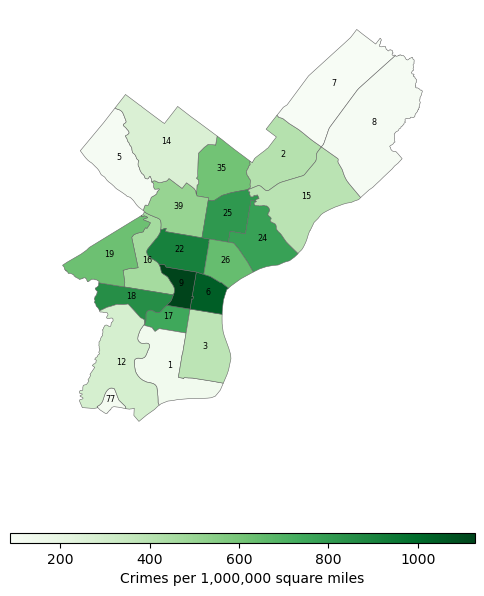

In [49]:
fig, ax = plt.subplots(1, figsize=(12,8))
plt.xticks(rotation=90)
map_and_stats.plot(
    column='crimeCtPArea',
    cmap='Greens',
    linewidth=0.4,
    ax=ax,
    edgecolor='.4',
    legend=True,
    legend_kwds={
        'label': "Crimes per 1,000,000 square miles",
        'orientation': 'horizontal',
        'shrink': 0.5,
        'aspect': 50
    }
)
map_and_stats.apply(lambda x: ax.annotate(text=x['DIST_NUM'], xy=x.geometry.centroid.coords[0], ha='center', fontsize='xx-small'), axis=1)
ax.axis('off')

In [45]:
# Investigate Pearson's

y = map_and_stats['CRN'] #crash numbers
x = map_and_stats['objectid'] #crime rate/1e6 sqmi

import scipy

r, p = scipy.stats.pearsonr(x, y)



In [46]:
print(r, p)

0.7163042800242347 0.00017709052631052354


In [47]:
np.corrcoef(x, y)

array([[1.        , 0.71630428],
       [0.71630428, 1.        ]])